In [1]:
import ROOT
from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F

from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian,RooExponential, \
                 RooBinning, kRed, kBlue, kDotted,TString,RooAbsData, RooPlot, TCut, RooAbsData, RooFit , RooStats               

In [2]:
import sys
sys.path.append('/home/chasenberg/repos/')
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random
import ROOT 
from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp
import root_numpy as ry 

import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

from tqdm import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

Declare data directories and read files
--------------------------------------

In [4]:
#directories and files 
mc_dir_randomPV = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/'
mc_file_randomPV= 'Bd2JpsiKS_random.root'
mc_dir_randomPV = os.path.join(mc_dir_randomPV, mc_file_randomPV)

mc_dir_bestPV = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/'
mc_file_bestPV= 'Bd2JpsiKS_pv_selected.root'
mc_dir_bestPV = os.path.join(mc_dir_bestPV, mc_file_bestPV)

mc_dir_noHandling = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/'
mc_file_noHandling= 'Bd2JpsiKS_bestPV.root'
mc_dir_noHandling = os.path.join(mc_dir_noHandling, mc_file_bestPV)

In [5]:
#Treename and cut for data
tree_data = 'Bd2JpsiKS'
cut_string_randomPV = 'B0_FitDaughtersConst_M_flat<5450&B0_FitDaughtersConst_M_flat>5200'
cut_string_bestPV = 'B0_FitDaughtersConst_M_flat<5450&B0_FitDaughtersConst_M_flat>5200&idxPV==0'

Load data from ROOT files
-------------------------------------------------------

In [6]:
signal_dataframe_randomPV  = rp.read_root(mc_dir_randomPV,key=tree_data,where=cut_string_randomPV, flatten=False)
signal_dataframe_randomPV  = signal_dataframe_randomPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_randomPV  = signal_dataframe_randomPV.dropna()

In [7]:
signal_dataframe_randomPV.shape

(501573, 77)

In [8]:
signal_dataframe_bestPV = rp.read_root(mc_dir_bestPV,key=tree_data,where=cut_string_bestPV, flatten=False)
signal_dataframe_bestPV = signal_dataframe_bestPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_bestPV = signal_dataframe_bestPV.dropna()
#real_dataframe_wrongPV = pd.concat([real_dataframe_wrongPV_2015])'''

In [9]:
signal_dataframe_noHandling  = rp.read_root(mc_dir_noHandling,key=tree_data,where=cut_string_randomPV, flatten=False)
signal_dataframe_noHandling  = signal_dataframe_noHandling.replace([np.inf, -np.inf], np.nan)
signal_dataframe_noHandling  = signal_dataframe_noHandling.dropna()

Check correlation matrix in terms of decay-time-biasing
---------------------------------------------------------------------------------

In [10]:
signal_dataframe_bestPV['B0_FitDaughtersConst_IPCHI2_nDOF'] = signal_dataframe_bestPV.B0_FitDaughtersConst_IPCHI2_flat /  signal_dataframe_bestPV.B0_FitDaughtersConst_nDOF_flat
signal_dataframe_randomPV['B0_FitDaughtersConst_IPCHI2_nDOF'] = signal_dataframe_randomPV.B0_FitDaughtersConst_IPCHI2_flat /  signal_dataframe_randomPV.B0_FitDaughtersConst_nDOF_flat
signal_dataframe_noHandling['B0_FitDaughtersConst_IPCHI2_nDOF'] = signal_dataframe_noHandling.B0_FitDaughtersConst_IPCHI2_flat /  signal_dataframe_noHandling.B0_FitDaughtersConst_nDOF_flat

In [11]:
variables = [
            'B0_FitPVConst_MinIPCHI2anyPV_flat',
            #'B0_FitPVConst_IPCHI2_flat',
            'B0_FitPVConst_tau_flat',
            'BDTresponse_wrongPV',
            'B0_FitDaughtersConst_IPCHI2_flat'
            ]

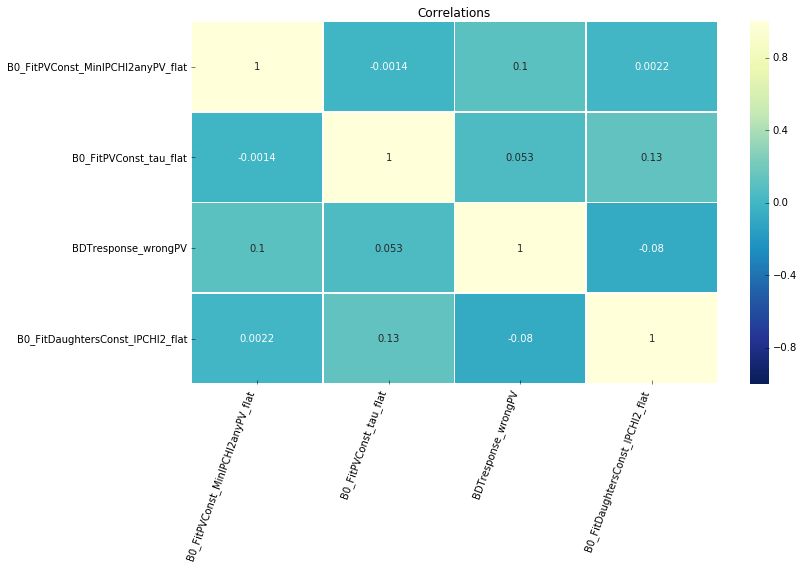

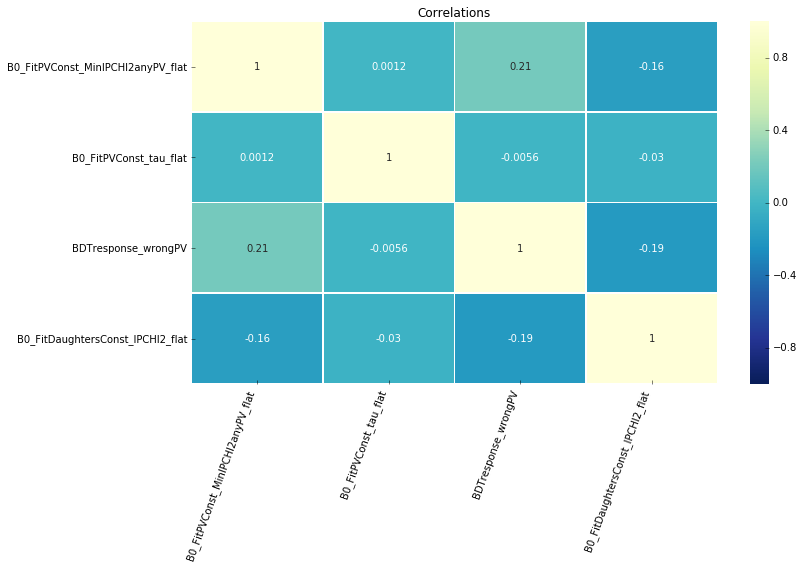

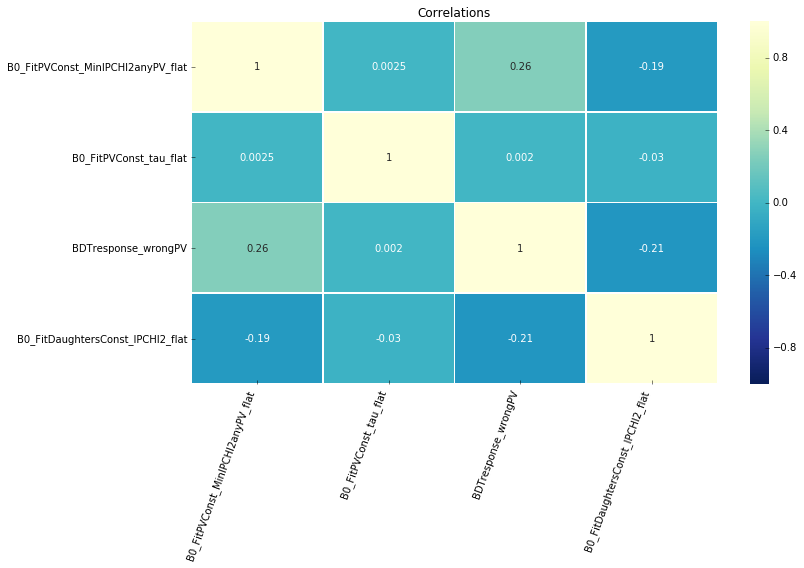

In [12]:
plt.figure(figsize=(12,8))
plot_correlations(signal_dataframe_bestPV[variables], annot=True)
#plt.savefig('/home/chasenberg/plots/wrong_pv/correlation_data.png')
plt.show()
plt.figure(figsize=(12,8))


plt.figure(figsize=(12,8))
plot_correlations(signal_dataframe_randomPV[variables], annot=True)
#plt.savefig('/home/chasenberg/plots/wrong_pv/correlation_data.png')
plt.show()
plt.figure(figsize=(12,8))

plt.figure(figsize=(12,8))
plot_correlations(signal_dataframe_noHandling[variables], annot=True)
#plt.savefig('/home/chasenberg/plots/wrong_pv/correlation_data.png')
plt.show()
plt.figure(figsize=(12,8))



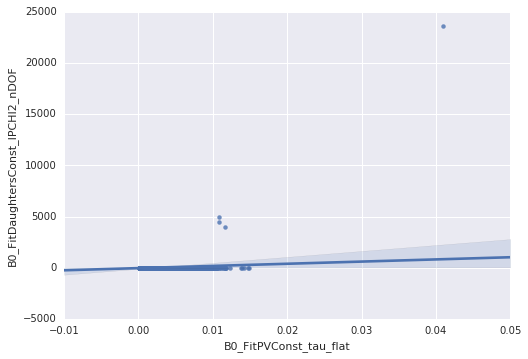

In [13]:
import seaborn as sns; sns.set(color_codes=True)
 
ax = sns.regplot(x="B0_FitPVConst_tau_flat", y="B0_FitDaughtersConst_IPCHI2_nDOF", data=signal_dataframe_bestPV.sample(20000))

In [14]:
'''import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

test = signal_dataframe_bestPV.sample(10000)
# the random data
x = test.B0_FitPVConst_tau_flat
y = test.B0_FitDaughtersConst_IPCHI2_nDOF


fig, axScatter = plt.subplots(figsize=(5.5, 5.5))

# the scatter plot:
axScatter.scatter(x, y)
axScatter.set_aspect(1.)

# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)
b
# make some labels invisible
plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(),
         visible=False)

# now determine nice limits by hand:
binwidth = 0.25
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1)*binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')

# the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.

#axHistx.axis["bottom"].major_ticklabels.set_visible(False)
for tl in axHistx.get_xticklabels():
    tl.set_visible(False)
axHistx.set_yticks([0, 50, 100])

#axHisty.axis["left"].major_ticklabels.set_visible(False)
for tl in axHisty.get_yticklabels():
    tl.set_visible(False)
axHisty.set_xticks([0, 50, 100])

plt.draw()
plt.show()
'''

'import numpy as np\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.axes_grid1 import make_axes_locatable\n\ntest = signal_dataframe_bestPV.sample(10000)\n# the random data\nx = test.B0_FitPVConst_tau_flat\ny = test.B0_FitDaughtersConst_IPCHI2_nDOF\n\n\nfig, axScatter = plt.subplots(figsize=(5.5, 5.5))\n\n# the scatter plot:\naxScatter.scatter(x, y)\naxScatter.set_aspect(1.)\n\n# create new axes on the right and on the top of the current axes\n# The first argument of the new_vertical(new_horizontal) method is\n# the height (width) of the axes to be created in inches.\ndivider = make_axes_locatable(axScatter)\naxHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)\naxHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)\nb\n# make some labels invisible\nplt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(),\n         visible=False)\n\n# now determine nice limits by hand:\nbinwidth = 0.25\nxymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])\

## Scatterplots for bestPV selection

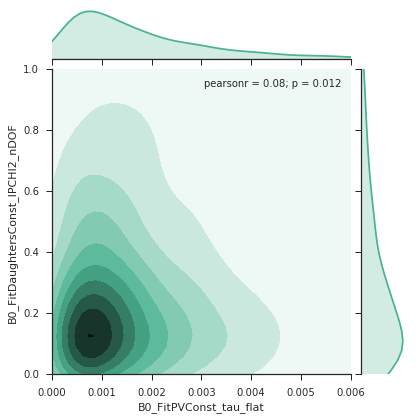

In [15]:
import numpy as np
from scipy.stats import kendalltau
import seaborn as sns
sns.set(style="ticks")

test = signal_dataframe_bestPV.sample(1000)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['B0_FitDaughtersConst_IPCHI2_nDOF']

sns.jointplot(x, y, kind="kde", xlim=[0,0.006],ylim=[0,1.0],color="#4CB391")


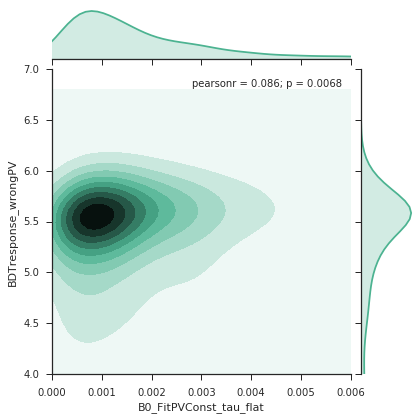

In [16]:
import numpy as np
from scipy.stats import kendalltau
import seaborn as sns
sns.set(style="ticks")

test = signal_dataframe_bestPV.sample(1000)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['BDTresponse_wrongPV']

sns.jointplot(x, y, kind="kde", xlim=[0,0.006],ylim=[4,7],color="#4CB391")

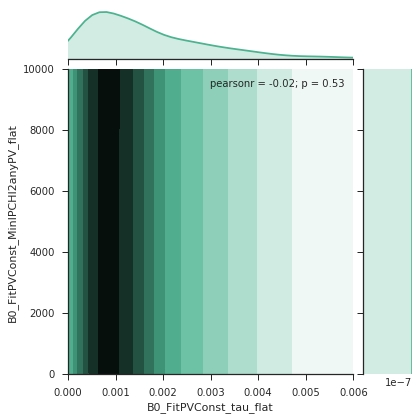

In [17]:
import numpy as np
from scipy.stats import kendalltau
import seaborn as sns
sns.set(style="ticks")

test = signal_dataframe_bestPV.sample(1000)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['B0_FitPVConst_MinIPCHI2anyPV_flat']

sns.jointplot(x, y, kind="kde", xlim=[0,0.006],ylim=[0,10000],color="#4CB391")

## Scatterplots for noHandling

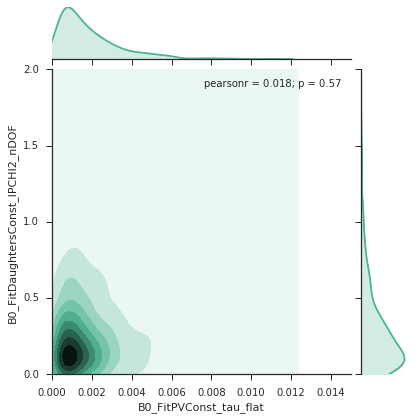

In [52]:
import numpy as np
from scipy.stats import kendalltau
import seaborn as sns
sns.set(style="ticks")

ylim = 2
ylim_str = str(ylim)
test = signal_dataframe_noHandling.query('B0_FitDaughtersConst_IPCHI2_nDOF<'+ylim_str).sample(1000)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['B0_FitDaughtersConst_IPCHI2_nDOF']

g = sns.jointplot(x, y, kind="kde", xlim=[0,0.015],ylim=[0,ylim],color="#4CB391")
g.savefig("/home/chasenberg/plots/wrong_pv/decay_time_correlations/no_handling_ipchi2_ndof_kde.pdf")

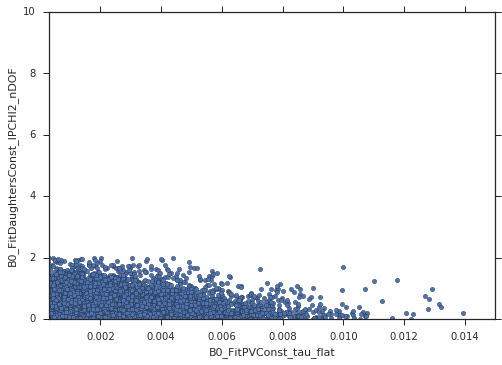

In [57]:
import numpy as np
import matplotlib.pyplot as plt
 
ylim = 6
test = signal_dataframe_noHandling.query('B0_FitDaughtersConst_IPCHI2_nDOF<'+ylim_str).sample(20000)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['B0_FitDaughtersConst_IPCHI2_nDOF']
plt.scatter(x,y)
plt.xlim(0.0003,0.015)
plt.ylim(0,ylim+4)
plt.xlabel('B0_FitPVConst_tau_flat')
plt.ylabel('B0_FitDaughtersConst_IPCHI2_nDOF')
plt.savefig("/home/chasenberg/plots/wrong_pv/decay_time_correlations/no_handling_ipchi2_ndof_scatter.pdf")

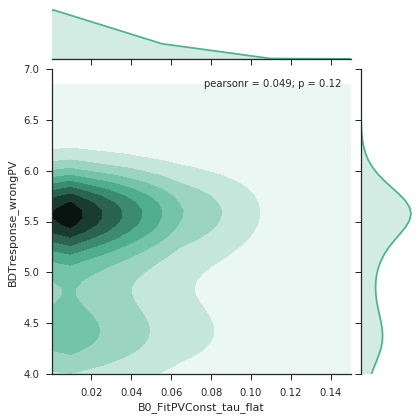

In [44]:
import numpy as np
from scipy.stats import kendalltau
import seaborn as sns
sns.set(style="ticks")

test = signal_dataframe_noHandling.sample(1000)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['BDTresponse_wrongPV']

g = sns.jointplot(x, y, kind="kde", xlim=[0.0003,0.15],ylim=[4,7],color="#4CB391")
g.savefig("/home/chasenberg/plots/wrong_pv/decay_time_correlations/no_handling_wrongPV_kde.pdf")

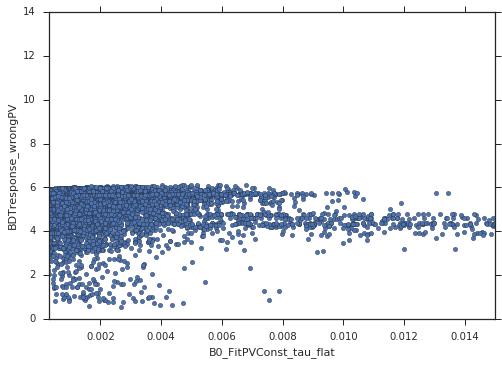

In [58]:
import numpy as np
import matplotlib.pyplot as plt
 
ylim = 10
test = signal_dataframe_noHandling.sample(10000)#.query('B0_FitDaughtersConst_IPCHI2_nDOF<'+ylim_str)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['BDTresponse_wrongPV']
plt.scatter(x,y)
plt.xlim(0.0003,0.015)
plt.ylim(0,ylim+4)
plt.xlabel('B0_FitPVConst_tau_flat')
plt.ylabel('BDTresponse_wrongPV')
plt.savefig("/home/chasenberg/plots/wrong_pv/decay_time_correlations/no_handling_wrongPV_scatter.pdf")

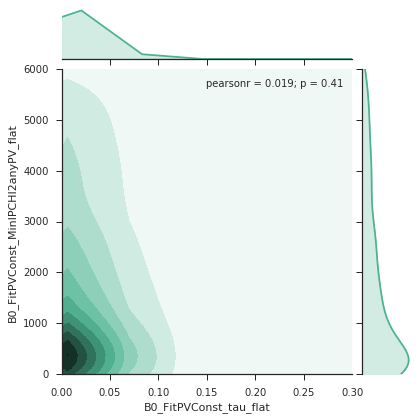

In [46]:
import numpy as np
from scipy.stats import kendalltau
import seaborn as sns
sns.set(style="ticks")

ylim = 6000
ylim_str = str(ylim)
test = signal_dataframe_noHandling.query('B0_FitPVConst_MinIPCHI2anyPV_flat<'+ylim_str).sample(2000)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['B0_FitPVConst_MinIPCHI2anyPV_flat']

g = sns.jointplot(x, y, kind="kde", xlim=[0.0003,0.3],ylim=[0,ylim],color="#4CB391")
g.savefig("/home/chasenberg/plots/wrong_pv/decay_time_correlations/no_handling_minipchi2_kde.pdf")

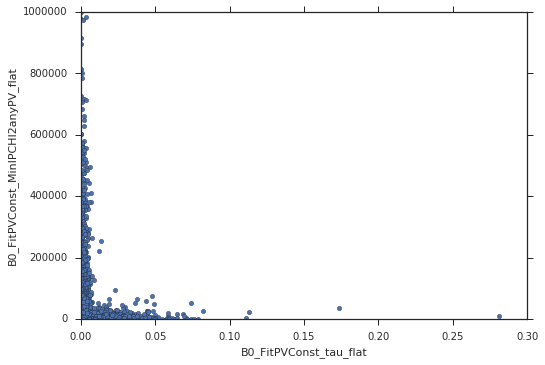

In [47]:
import numpy as np
import matplotlib.pyplot as plt
 
ylim = 1000000
test = signal_dataframe_noHandling.sample(10000)#.query('B0_FitDaughtersConst_IPCHI2_nDOF<'+ylim_str)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['B0_FitPVConst_MinIPCHI2anyPV_flat']
plt.scatter(x,y)
plt.xlim(0,0.3)
plt.ylim(0,ylim+4)
plt.xlabel('B0_FitPVConst_tau_flat')
plt.ylabel('B0_FitPVConst_MinIPCHI2anyPV_flat')
plt.savefig("/home/chasenberg/plots/wrong_pv/decay_time_correlations/no_handling_wrongPV_scatter.pdf")

## Scatterplots for randomPV selection

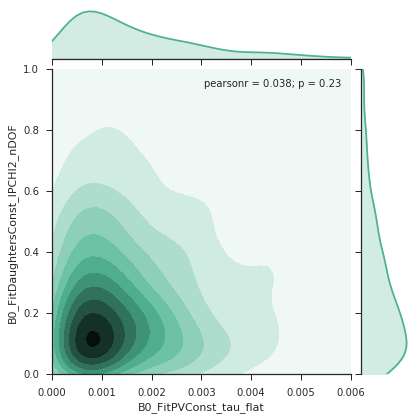

In [24]:
import numpy as np
from scipy.stats import kendalltau
import seaborn as sns
sns.set(style="ticks")

ylim = 1
ylim_str = str(ylim)
test = signal_dataframe_randomPV.query('B0_FitDaughtersConst_IPCHI2_nDOF<'+ylim_str).sample(1000)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['B0_FitDaughtersConst_IPCHI2_nDOF']

sns.jointplot(x, y, kind="kde", xlim=[0,0.006],ylim=[0,ylim],color="#4CB391")

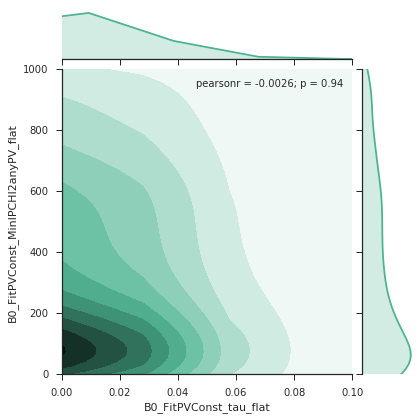

In [25]:
import numpy as np
from scipy.stats import kendalltau
import seaborn as sns
sns.set(style="ticks")

ylim = 1000
ylim_str = str(ylim)
test = signal_dataframe_randomPV.query('B0_FitPVConst_MinIPCHI2anyPV_flat<'+ylim_str).sample(1000)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['B0_FitPVConst_MinIPCHI2anyPV_flat']

sns.jointplot(x, y, kind="kde", xlim=[0,0.1],ylim=[0,ylim],color="#4CB391")

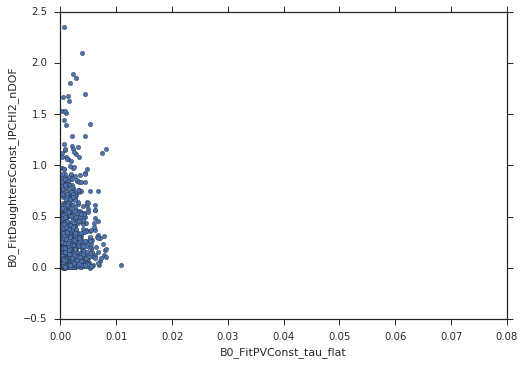

In [26]:
import numpy as np
import matplotlib.pyplot as plt
 

test = signal_dataframe_bestPV.sample(1000)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['B0_FitDaughtersConst_IPCHI2_nDOF']
plt.scatter(x,y)
plt.xlim(0,0.08)
plt.xlabel('B0_FitPVConst_tau_flat')
plt.ylabel('B0_FitDaughtersConst_IPCHI2_nDOF')

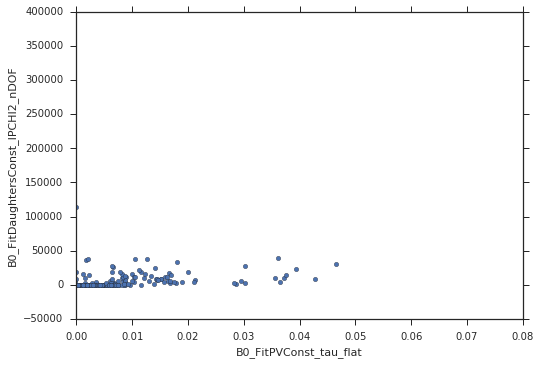

In [27]:
import numpy as np
import matplotlib.pyplot as plt
 

test = signal_dataframe_noHandling.sample(1000)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['B0_FitDaughtersConst_IPCHI2_nDOF']
plt.scatter(x,y)
plt.xlim(0,0.08)
plt.xlabel('B0_FitPVConst_tau_flat')
plt.ylabel('B0_FitDaughtersConst_IPCHI2_nDOF')

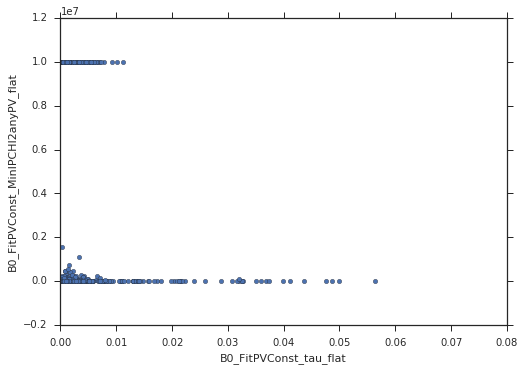

In [28]:
import numpy as np
import matplotlib.pyplot as plt
 

test = signal_dataframe_noHandling.sample(1000)
# the random data
x = test['B0_FitPVConst_tau_flat']
y = test['B0_FitPVConst_MinIPCHI2anyPV_flat']
plt.scatter(x,y)
plt.xlim(0,0.08)
plt.xlabel('B0_FitPVConst_tau_flat')
plt.ylabel('B0_FitPVConst_MinIPCHI2anyPV_flat')